### Análisis EDA
En nuestro caso, durante el proceso de ETL ya se ha hecho gran cantidad de limpiezas y pruebas contables (explicadas en el "entregable 2" y en los jpynb del 01 al 03) por lo que centraremos el proceso del EDA en buscar anomalías en los datos, posibles outliers o errores.

In [1]:
#Importamos lo necesario para trabajar el EDA y seteamos 
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import ast
import psycopg2 as ps
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


Para el análisis EDA, lo haremos directamente sobre la base de datos de DBeaver.

In [4]:
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#traemos los datos de la tabla empresas_IBEX35
cur.execute("SELECT * FROM empresas_IBEX35")
#guardamos los resultados en una variable
empresas_IBEX35 = cur.fetchall()
#creamos un dataframe con los resultadoS
empresas_IBEX35 = pd.DataFrame(empresas_IBEX35, columns=[ 'nombre','ticker' ,'sector', 'subsector'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
empresas_IBEX35

,nombre,ticker,sector,subsector
0,Grifols S.A.,GRF.MC,Healthcare,Drug Manufacturers - General
1,Indra A,IDR.MC,Technology,Information Technology Services
2,Caixabank SA,CABK.MC,Financial Services,Banks - Regional
3,Repsol,REP.MC,Energy,Oil & Gas Integrated
4,Telefonica,TEF.MC,Communication Services,Telecom Services
5,Bankinter,BKT.MC,Financial Services,Banks - Regional
6,Amadeus IT Group S.A.,AMS.MC,Technology,Information Technology Services
7,Mapfre,MAP.MC,Financial Services,Insurance - Diversified
8,Industria de Diseno Textil SA,ITX.MC,Consumer Cyclical,Apparel Retail
9,Banco de Sabadell S.A,SAB.MC,Financial Services,Banks - Diversified


Observando el df vemos que la columna ID no tiene sentido, la primarykey debería ser el ticker ya que es un valor único para cada empresa y sobre la cual se va a relacionar con el resto de las tablas. 

In [6]:
#Eliminamos de la base de datos la columna id y marcamos como primary key la columna ticker
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#guardamos los cambios
conn.commit()
#traemos los datos de la tabla empresas_IBEX35
cur.execute("SELECT * FROM empresas_IBEX35")
#guardamos los resultados en una variable
empresas_IBEX35 = cur.fetchall()
#creamos un dataframe con los resultadoS
empresas_IBEX35 = pd.DataFrame(empresas_IBEX35, columns=['nombre','ticker' ,'sector', 'subsector'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
empresas_IBEX35
#cerramos el cursor y la conexión
cur.close()
conn.close()


In [7]:
empresas_IBEX35

,nombre,ticker,sector,subsector
0,Grifols S.A.,GRF.MC,Healthcare,Drug Manufacturers - General
1,Indra A,IDR.MC,Technology,Information Technology Services
2,Caixabank SA,CABK.MC,Financial Services,Banks - Regional
3,Repsol,REP.MC,Energy,Oil & Gas Integrated
4,Telefonica,TEF.MC,Communication Services,Telecom Services
5,Bankinter,BKT.MC,Financial Services,Banks - Regional
6,Amadeus IT Group S.A.,AMS.MC,Technology,Information Technology Services
7,Mapfre,MAP.MC,Financial Services,Insurance - Diversified
8,Industria de Diseno Textil SA,ITX.MC,Consumer Cyclical,Apparel Retail
9,Banco de Sabadell S.A,SAB.MC,Financial Services,Banks - Diversified


In [8]:
#analizamos la tabla empresas_IBEX35
empresas_IBEX35.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   nombre     35 non-null     object
 1   ticker     35 non-null     object
 2   sector     35 non-null     object
 3   subsector  35 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [9]:
empresas_IBEX35.describe(include='all')

,nombre,ticker,sector,subsector
count,35,35,35,35
unique,35,35,11,23
top,Grifols S.A.,GRF.MC,Industrials,Banks - Regional
freq,1,1,8,3


In [10]:
#hacemos un conteo de los valores nulos
empresas_IBEX35.isnull().sum()

nombre       0
ticker       0
sector       0
subsector    0
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Industrials'),
  Text(1, 0, 'Utilities'),
  Text(2, 0, 'Financial Services'),
  Text(3, 0, 'Real Estate'),
  Text(4, 0, 'Healthcare'),
  Text(5, 0, 'Technology'),
  Text(6, 0, 'Basic Materials'),
  Text(7, 0, 'Consumer Cyclical'),
  Text(8, 0, 'Communication Services'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Specialty Retailers')])

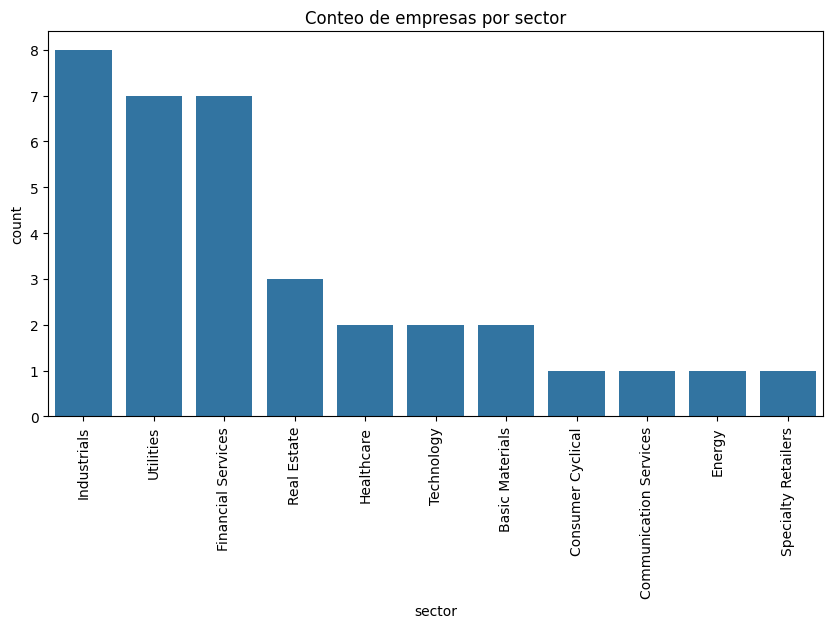

In [39]:
#vemos un barplot de los sectores
plt.figure(figsize=(10,5))
sns.countplot(data=empresas_IBEX35, x='sector', order=empresas_IBEX35['sector'].value_counts().index)
plt.title('Conteo de empresas por sector')
plt.xticks(rotation=90)


In [41]:
#Comprobamos que cada subsector pertenezca a un sector
#creamos un dataframe con los sectores y subsectores
sectores_subsectores = empresas_IBEX35[['sector', 'subsector']].drop_duplicates()
sectores_subsectores.describe(include='all')

,sector,subsector
count,23,23
unique,11,23
top,Industrials,Drug Manufacturers - General
freq,6,1


# Tabla empresas ibex35

Observamos que existen 35 valores (35 empresas dentro del IBEX 35) y que tanto el Ticker como el nombre son 35 valores únicos ya que cada empresa tiene un nombre y ticker diferentes. 

En cuanto a los sectores, vemos que existen 11 sectores diferentes y que el top 3 son industrials, utilities y financial services (representan 22 de 35 empresas entre ellos).

Comprobamos también que cada subsector pertenezca a un solo sector para asegurar la veracidad de los datos. 

Los tipos de las columnas son correctos al ser todos object ya que son textos.


In [101]:
#Cargamos la tabla ratios_ticker_año_IBEX35
#conectamos a la base de datos
#Eliminamos de la base de datos la columna id y marcamos como primary key la columna ticker
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Traemos los datos de la tabla ratios_ticker_año_IBEX35
cur.execute('SELECT * FROM "ratios_ticker_año_IBEX35"')
#guardamos los resultados en una variable
ratios_ticker_año_IBEX35 = cur.fetchall()
#creamos un dataframe con los resultadoS
ratios_ticker_año_IBEX35 = pd.DataFrame(ratios_ticker_año_IBEX35, columns=['id','ticker', 'año', 'PER', 'ROE','EV/EBIT', 'Dividend Yield','Deuda_finan/EBIT'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
ratios_ticker_año_IBEX35

,id,ticker,año,PER,ROE,EV/EBIT,Dividend Yield,Deuda_finan/EBIT
0,2176,ACS.MC,2020,6.763836,0.253948,21.638370,0.0987,23.209320
1,2177,ACS.MC,2021,-7.718406,-0.115541,151.199289,0.0915,195.413346
2,2178,ACS.MC,2022,9.477766,0.120458,20.199583,0.0858,23.057017
3,2179,ACS.MC,2023,12.512750,0.146380,18.219412,0.0525,17.719905
4,2180,ACS.MC,2024,14.950232,0.175550,15.725971,0.0421,15.203906
...,...,...,...,...,...,...,...,...
140,2316,TEF.MC,2024,-453.260816,-0.002533,23.830318,0.0761,19.850633
141,2317,UNI.MC,2021,1.666680,0.175983,90.201863,0.0143,109.779866
142,2318,UNI.MC,2022,8.224456,0.042945,281.395171,0.0233,288.829624
143,2319,UNI.MC,2023,7.755769,0.040144,302.784508,0.0641,324.208845


In [102]:
ratios_ticker_año_IBEX35.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                145 non-null    int64  
 1   ticker            145 non-null    object 
 2   año               145 non-null    int64  
 3   PER               145 non-null    float64
 4   ROE               145 non-null    float64
 5   EV/EBIT           145 non-null    float64
 6   Dividend Yield    145 non-null    float64
 7   Deuda_finan/EBIT  145 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 9.2+ KB


In [103]:
ratios_ticker_año_IBEX35.describe(include=float).T

,count,mean,std,min,25%,50%,75%,max
PER,145.0,13.645239,156.166807,-767.642175,5.387300,10.401757,15.156022,1458.726551
ROE,145.0,0.131003,0.128516,-0.248180,0.071486,0.117346,0.190567,0.533169
EV/EBIT,145.0,24.872454,186.729919,-1196.383766,14.323139,20.219944,48.286080,462.069324
Dividend Yield,145.0,0.051514,0.033860,0.000600,0.024700,0.046900,0.069000,0.160300
Deuda_finan/EBIT,145.0,19.483470,173.833033,-1420.914787,6.501914,13.143799,40.408853,450.806104


In [104]:
#hacemos un conteo de los valores nulos
ratios_ticker_año_IBEX35.isnull().sum()

id                  0
ticker              0
año                 0
PER                 0
ROE                 0
EV/EBIT             0
Dividend Yield      0
Deuda_finan/EBIT    0
dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'PER'),
  Text(1, 0, 'ROE'),
  Text(2, 0, 'EV/EBIT'),
  Text(3, 0, 'Dividend Yield'),
  Text(4, 0, 'Deuda_finan/EBIT')])

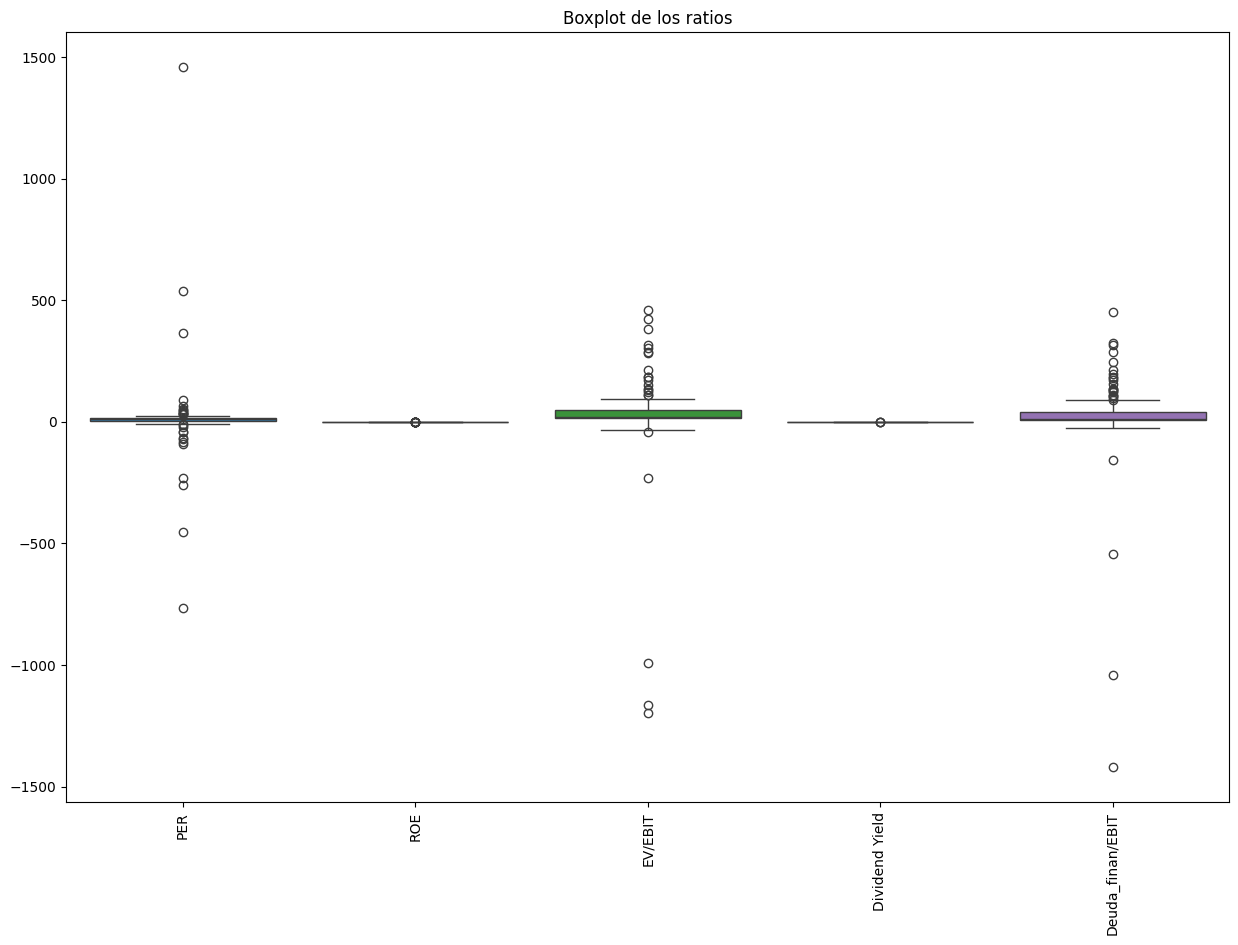

In [108]:
#Observamos que no existen valores nulos en la tabla ratios_ticker_año_IBEX35
#vamos a hacer un boxplot de los ratios para ver si hay outliers
plt.figure(figsize=(15,10))
sns.boxplot(data=ratios_ticker_año_IBEX35[['PER', 'ROE','EV/EBIT', 'Dividend Yield','Deuda_finan/EBIT']])
plt.title('Boxplot de los ratios')
plt.xticks(rotation=90)



## Tabla ratios ticker_año_ibex35

Observamos que existen outliers en los ratios PER, EV/EBIT y deuda financiera/EBIT. Esto se debe a_

**PER (Price to Earnings Ratio):**

Los valores atípicos en el PER suelen aparecer cuando los beneficios netos son excepcionalmente bajos o negativos. Como el PER divide el precio de la acción entre el beneficio por acción, un beneficio cercano a cero dispara el ratio, y un beneficio negativo lo vuelve inválido o erróneamente interpretado. Esto ocurre frecuentemente en empresas cíclicas en recesión o compañías en fase de inversión o reestructuración.

**EV/EBIT (Enterprise Value / Earnings Before Interest and Taxes):**

Outliers en el EV/EBIT pueden surgir cuando el EBIT es muy reducido o incluso negativo, lo que infla artificialmente el ratio. También puede pasar cuando el valor de empresa (EV) es muy alto por expectativas de mercado, adquisiciones o apalancamiento. En empresas en pérdidas operativas, este ratio pierde utilidad, y en negocios con fuerte crecimiento especulativo, puede sobredimensionarse.

**Deuda financiera / EBIT:**

Este ratio refleja la capacidad de una empresa para repagar su deuda con beneficios operativos. Valores extremadamente altos (outliers) se dan cuando el EBIT se hunde, por ejemplo, en años de crisis o pérdidas operativas, mientras la deuda se mantiene. También puede indicar una estructura financiera desequilibrada o modelos de negocio muy apalancados (como infraestructura o utilities).

En conclusión, esta tabla tiene los tipos de datos correctos, no existen nulos y todos los outliers tienen su explicación en la naturaleza de los ratios ya que resultados o EBITs negativos o tendentes a 0 pueden desvirtuar los ratios y convertirlos en outliers.

In [16]:
#cargamos los datos de la tabla ratios_beta_IBEX35
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Traemos los datos de la tabla ratios_beta_IBEX35
cur.execute('SELECT * FROM "ratios_beta_IBEX35"')
#guardamos los resultados en una variable
ratios_beta_IBEX35 = cur.fetchall()
#creamos un dataframe con los resultadoS
ratios_beta_IBEX35 = pd.DataFrame(ratios_beta_IBEX35, columns=['ticker', 'beta'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
ratios_beta_IBEX35

,ticker,beta
0,GRF.MC,0.7062
1,IDR.MC,0.8588
2,CABK.MC,1.2257
3,REP.MC,1.0146
4,TEF.MC,0.8370
5,BKT.MC,1.1781
6,AMS.MC,1.1865
7,MAP.MC,0.9444
8,ITX.MC,1.0116
9,SAB.MC,1.6560


In [14]:
#Convertimos la columna beta en la primary key de la tabla ratios_beta_IBEX35
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#convertimos la columna "Ticker" en la primary key de la tabla ratios_beta_IBEX35
cur.execute('ALTER TABLE "ratios_beta_IBEX35" DROP CONSTRAINT IF EXISTS "ratios_beta_IBEX35_pkey"')
cur.execute('ALTER TABLE "ratios_beta_IBEX35" ADD PRIMARY KEY ("Ticker")')
conn.commit()
cur.close()
conn.close()

In [17]:
ratios_beta_IBEX35.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  36 non-null     object 
 1   beta    36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes


In [18]:
ratios_beta_IBEX35[ratios_beta_IBEX35['ticker'] == '^IBEX']

,ticker,beta
34,^IBEX,1.0


In [19]:
ratios_beta_IBEX35.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ticker,36,36,GRF.MC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beta,36.0,NaN,NaN,NaN,0.952678,0.315491,0.4302,0.714075,0.93975,1.10135,1.6578


([0], [Text(0, 0, 'beta')])

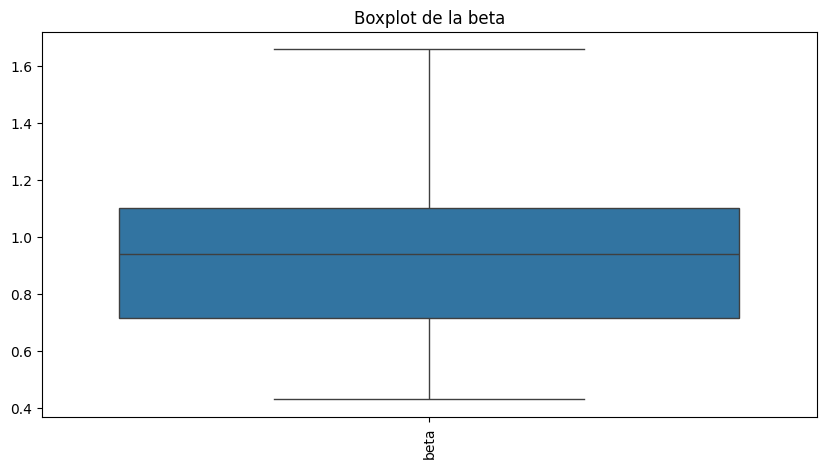

In [117]:
plt.figure(figsize=(10,5))
sns.boxplot(data=ratios_beta_IBEX35[['beta']])
plt.title('Boxplot de la beta')
plt.xticks(rotation=90)

## Tabla Ratios_beta_IBEX 35
** **
En primer lugar, convertimos los tickers en primary key ya que son valores únicos para esta tabla y observamos que hay 36, las 35 empresas más la propia beta del índice. 

Se hace una comprobación estadística para ver que la beta del IBEX es igual a 1 y no se observan outliers ya que todos los valores, como máximo están entre 0 y 2 con respecto al índice lo cual tiene sentido estadístico. 

In [23]:
#Cargamos los datos de la tabla contizaciones_IBEX35
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Traemos los datos de la tabla cotizaciones_IBEX35
cur.execute('SELECT * FROM "Cotizaciones_IBEX35"')
#guardamos los resultados en una variable
contizaciones_IBEX35 = cur.fetchall()
#creamos un dataframe con los resultadoS
contizaciones_IBEX35 = pd.DataFrame(contizaciones_IBEX35, columns=['Ticker', 'Fecha', 'Cierre', 'Volumen', 'Variación', 'Año'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
contizaciones_IBEX35

,Ticker,Fecha,Cierre,Volumen,Variación,Año
0,GRF.MC,2020-01-02,30.99,392672.0,NaN,2020
1,GRF.MC,2020-01-03,31.02,641127.0,0.0009,2020
2,GRF.MC,2020-01-06,31.01,386910.0,-0.0003,2020
3,GRF.MC,2020-01-07,31.86,2090693.0,0.0274,2020
4,GRF.MC,2020-01-08,31.83,609008.0,-0.0009,2020
...,...,...,...,...,...,...
47640,PUIG.MC,2025-04-25,16.28,484878.0,0.0106,2025
47641,PUIG.MC,2025-04-28,16.56,555283.0,0.0172,2025
47642,PUIG.MC,2025-04-29,16.69,878013.0,0.0079,2025
47643,PUIG.MC,2025-04-30,16.43,404284.0,-0.0156,2025


In [24]:
contizaciones_IBEX35.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47645 entries, 0 to 47644
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     47645 non-null  object 
 1   Fecha      47645 non-null  object 
 2   Cierre     47645 non-null  float64
 3   Volumen    47645 non-null  float64
 4   Variación  47609 non-null  float64
 5   Año        47645 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 2.2+ MB


In [26]:
#Observamos que todas las columnas tienen el tipo de dato correcto salvo la columna fecha que la convertimos a datetime en la base de datos y creamos una columna ID como primary key
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#convertimos la columna "Fecha" en la primary key de la tabla cotizaciones_IBEX35
cur.execute('ALTER TABLE "Cotizaciones_IBEX35" DROP CONSTRAINT IF EXISTS "Cotizaciones_IBEX35_pkey"')
cur.execute('ALTER TABLE "Cotizaciones_IBEX35" ADD COLUMN "ID" SERIAL PRIMARY KEY')
#convertimos la columna "Fecha" en el tipo de dato datetime
cur.execute('ALTER TABLE "Cotizaciones_IBEX35" ALTER COLUMN "Fecha" TYPE DATE USING "Fecha"::DATE')
#guardamos los datos en una variable
cur.execute('SELECT * FROM "Cotizaciones_IBEX35"')
#guardamos los resultados en una variable
contizaciones_IBEX35 = cur.fetchall()



cur.close()
conn.close()

#mostramos el dataframe
contizaciones_IBEX35

[('GRF.MC', datetime.date(2020, 1, 2), 30.99, 392672.0, nan, 2020, 1),
 ('GRF.MC', datetime.date(2020, 1, 3), 31.02, 641127.0, 0.0009, 2020, 2),
 ('GRF.MC', datetime.date(2020, 1, 6), 31.01, 386910.0, -0.0003, 2020, 3),
 ('GRF.MC', datetime.date(2020, 1, 7), 31.86, 2090693.0, 0.0274, 2020, 4),
 ('GRF.MC', datetime.date(2020, 1, 8), 31.83, 609008.0, -0.0009, 2020, 5),
 ('GRF.MC', datetime.date(2020, 1, 9), 32.2, 947922.0, 0.0117, 2020, 6),
 ('GRF.MC', datetime.date(2020, 1, 10), 32.08, 591387.0, -0.0039, 2020, 7),
 ('GRF.MC', datetime.date(2020, 1, 13), 31.9, 454516.0, -0.0055, 2020, 8),
 ('GRF.MC', datetime.date(2020, 1, 14), 31.73, 2894156.0, -0.0052, 2020, 9),
 ('GRF.MC', datetime.date(2020, 1, 15), 31.86, 859030.0, 0.004, 2020, 10),
 ('GRF.MC', datetime.date(2020, 1, 16), 31.17, 868280.0, -0.0218, 2020, 11),
 ('GRF.MC', datetime.date(2020, 1, 17), 31.08, 978987.0, -0.0028, 2020, 12),
 ('GRF.MC', datetime.date(2020, 1, 20), 31.19, 558063.0, 0.0035, 2020, 13),
 ('GRF.MC', datetime.dat

In [29]:
#Convertimos la variable en un dataframe
cotizaciones_IBEX = pd.DataFrame(contizaciones_IBEX35, columns=['Ticker', 'Fecha', 'Cierre', 'Volumen', 'Variación', 'Año', 'ID'])
cotizaciones_IBEX

,Ticker,Fecha,Cierre,Volumen,Variación,Año,ID
0,GRF.MC,2020-01-02,30.99,392672.0,NaN,2020,1
1,GRF.MC,2020-01-03,31.02,641127.0,0.0009,2020,2
2,GRF.MC,2020-01-06,31.01,386910.0,-0.0003,2020,3
3,GRF.MC,2020-01-07,31.86,2090693.0,0.0274,2020,4
4,GRF.MC,2020-01-08,31.83,609008.0,-0.0009,2020,5
...,...,...,...,...,...,...,...
47640,PUIG.MC,2025-04-25,16.28,484878.0,0.0106,2025,47641
47641,PUIG.MC,2025-04-28,16.56,555283.0,0.0172,2025,47642
47642,PUIG.MC,2025-04-29,16.69,878013.0,0.0079,2025,47643
47643,PUIG.MC,2025-04-30,16.43,404284.0,-0.0156,2025,47644


In [30]:
cotizaciones_IBEX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47645 entries, 0 to 47644
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     47645 non-null  object 
 1   Fecha      47645 non-null  object 
 2   Cierre     47645 non-null  float64
 3   Volumen    47645 non-null  float64
 4   Variación  47609 non-null  float64
 5   Año        47645 non-null  int64  
 6   ID         47645 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 2.5+ MB


In [31]:
cotizaciones_IBEX.isnull().sum()

Ticker        0
Fecha         0
Cierre        0
Volumen       0
Variación    36
Año           0
ID            0
dtype: int64

In [32]:
cotizaciones_IBEX.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ticker,47645,36,GRF.MC,1365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fecha,47645,1365,2025-04-03,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cierre,47645.0,NaN,NaN,NaN,285.657286,1557.287353,0.21,4.5,13.01,24.88,13484.3
Volumen,47645.0,NaN,NaN,NaN,11281386.377437,35927290.831613,5074.0,502393.0,1240359.0,6380782.0,975212000.0
Variación,47609.0,NaN,NaN,NaN,0.00052,0.021587,-0.3493,-0.0095,0.0007,0.0107,0.2607
Año,47645.0,NaN,NaN,NaN,2022.208794,1.549351,2020.0,2021.0,2022.0,2024.0,2025.0
ID,47645.0,NaN,NaN,NaN,23823.0,13754.071125,1.0,11912.0,23823.0,35734.0,47645.0


### Tabla Cotizaciones_IBEX35
****

Al hacer el EDA de esta tabla observamos que, en inicio, teníamos problemas con los datos de la tabla ya que no tenía primary key (creada posteriormente) y los datos de la columna fecha no estaban en el formato correcto. 

En cuanto al análisis de columnas se ha observado: 

**Ticker:** no hay ningún valor nulo y 35 valores únicos (las 35 empresas y el índice) por lo que la columna es correcta.

**Fecha:** ningún valor nulo y 1365 valores únicos, todos los días de cotización desde el 01/01/2020 hasta el día de hoy. 

**Cierre:** observamos que no hay ningún valor negativo, el análisis de otras estadísticas o de outliers no tiene sentido aquí ya que el precio de cotización de una acción es totalmente independiente del de otra por lo que el análisis en conjunto nos llevaría a error.

**Volumen:** observamos que no hay ningún valor negativo, el análisis de otras estadísticas o de outliers no tiene sentido aquí ya que el volumen de cotización de una acción es totalmente independiente del de otra por lo que el análisis en conjunto nos llevaría a error.

**Variación:** Existen 36 valores nulos los cuales vamos a continuar manteniendo en el análisis. Estos valores nulos se deben a la forma en la que se calcula la variación (valor anterior-valor actual / valor anterior) ya que, para el primer día de cotización no existe un valor anterior. 

**Año:** ningún valor nulo y vemos que todos los datos están comprendidos entre 2020 y 2025 que es el plazo temporal del análisis. 

**ID:** es la columna primary key por lo que tenemos que observar que no hay ningún valor repetido. 

In [34]:
#Cargamos la tabla dividendos_IBEX35
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Traemos los datos de la tabla dividendos_IBEX35
cur.execute('SELECT * FROM "Dividendos_IBEX35"')
#guardamos los resultados en una variable
div_IBEX35 = cur.fetchall()
#creamos un dataframe con los resultados
dividendos_IBEX35 = pd.DataFrame(div_IBEX35, columns=['Ticker', 'Año', 'Dividendo', 'Precio_cierre', 'Dividend Yield'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
dividendos_IBEX35

,Ticker,Año,Dividendo,Precio_cierre,Dividend Yield
0,ACS.MC,2020,1.99,20.16,0.0987
1,ACS.MC,2021,1.72,18.79,0.0915
2,ACS.MC,2022,2.00,23.32,0.0858
3,ACS.MC,2023,1.96,37.36,0.0525
4,ACS.MC,2024,2.02,47.99,0.0421
...,...,...,...,...,...
159,UNI.MC,2021,0.01,0.70,0.0143
160,UNI.MC,2022,0.02,0.86,0.0233
161,UNI.MC,2023,0.05,0.78,0.0641
162,UNI.MC,2024,0.11,1.22,0.0902


In [7]:
#Observamos que la columna Precio_cierre_año y la columna Dividend Yield ya las tenemos en otra tabla por lo que las eliminamos. Ademas creamos una columna ID como primary key
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
cur.execute('ALTER TABLE "Dividendos_IBEX35" DROP CONSTRAINT IF EXISTS "Dividendos_IBEX35_pkey"')
cur.execute('ALTER TABLE "Dividendos_IBEX35" DROP COLUMN IF EXISTS "ID"')
cur.execute('ALTER TABLE "Dividendos_IBEX35" ADD COLUMN "ID" SERIAL PRIMARY KEY')
cur.execute('ALTER TABLE "Dividendos_IBEX35" DROP COLUMN IF EXISTS "Precio_cierre_año"')
cur.execute('ALTER TABLE "Dividendos_IBEX35" DROP COLUMN IF EXISTS "Dividendo_yield"')
#hacemos un commit para guardar los cambios
conn.commit()
cur.execute('SELECT * FROM "Dividendos_IBEX35"')
#cerramos el cursor y la conexión
cur.close()
conn.close()



In [13]:
#Cargamos la tabla dividendos_IBEX35
#conectamos a la base de datos
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Traemos los datos de la tabla dividendos_IBEX35
cur.execute('SELECT * FROM "Dividendos_IBEX35"')
#guardamos los resultados en una variable
div_IBEX35 = cur.fetchall()
dividendos_IBEX35 = pd.DataFrame(div_IBEX35, columns=['Ticker', 'Año', 'Dividendo', 'ID'])
#cerramos el cursor y la conexión
cur.close()
conn.close()
#mostramos el dataframe
dividendos_IBEX35

,Ticker,Año,Dividendo,ID
0,ACS.MC,2020,1.99,1
1,ACS.MC,2021,1.72,2
2,ACS.MC,2022,2.00,3
3,ACS.MC,2023,1.96,4
4,ACS.MC,2024,2.02,5
...,...,...,...,...
159,UNI.MC,2021,0.01,160
160,UNI.MC,2022,0.02,161
161,UNI.MC,2023,0.05,162
162,UNI.MC,2024,0.11,163


In [14]:
dividendos_IBEX35.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     164 non-null    object 
 1   Año        164 non-null    int64  
 2   Dividendo  164 non-null    float64
 3   ID         164 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 5.3+ KB


In [15]:
dividendos_IBEX35.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ticker,164,33,ACS.MC,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Año,164.0,NaN,NaN,NaN,2022.445122,1.62138,2020.0,2021.0,2022.5,2024.0,2025.0
Dividendo,164.0,NaN,NaN,NaN,0.805732,1.233672,0.0,0.16,0.45,1.0,9.76
ID,164.0,NaN,NaN,NaN,82.5,47.48684,1.0,41.75,82.5,123.25,164.0


In [16]:
dividendos_IBEX35.isnull().sum()

Ticker       0
Año          0
Dividendo    0
ID           0
dtype: int64

### Tabla Dividendos_IBEX35
****

Al hacer el EDA de esta tabla observamos que, en inicio, teníamos algunas columnas duplicadas que ya estaban en otras tablas por lo que se han eliminado. 

En cuanto al análisis de columnas se ha observado: 

**Ticker:** no hay ningún valor nulo y 35 valores únicos (las 35 empresas y el índice) por lo que la columna es correcta.

**Año:** ningún valor nulo y vemos que todos los datos están comprendidos entre 2020 y 2025 que es el plazo temporal del análisis. 

**Diviendo:** observamos que no hay ningún valor negativo, el análisis de otras estadísticas o de outliers no tiene sentido aquí ya que los dividendos de una acción son totalmente independiente de los de otra por lo que el análisis en conjunto nos llevaría a error.

**ID:** es la columna primary key por lo que tenemos que observar que no hay ningún valor repetido. 

In [18]:
#Cargamos la tabla Cuentas_PYG_IBEX35
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Traemos los datos de la tabla Cuentas_PYG_IBEX35
cur.execute('SELECT * FROM "Cuentas_PYG_IBEX35"')

cuentas_pyg= cur.fetchall()
cur.close()
conn.close()
cuentas_pyg

[('ACS.MC', 2020, 34937356000.0, 896050000.0),
 ('ACS.MC', 2021, 27836658000.0, -731870000.0),
 ('ACS.MC', 2022, 33615234000.0, 668227000.0),
 ('ACS.MC', 2023, 35737759000.0, 780123000.0),
 ('ACS.MC', 2024, 41633120000.0, 827580000.0),
 ('ACX.MC', 2020, 4668488000.0, 49049000.0),
 ('ACX.MC', 2021, 6705739000.0, 571882000.0),
 ('ACX.MC', 2022, 8688494000.0, 556054000.0),
 ('ACX.MC', 2023, 6607978000.0, 228128000.0),
 ('ACX.MC', 2024, 5413128000.0, 224946000.0),
 ('AENA.MC', 2020, 2180616000.0, -160748000.0),
 ('AENA.MC', 2021, 2318750000.0, -89584000.0),
 ('AENA.MC', 2022, 4182169000.0, 901499000.0),
 ('AENA.MC', 2023, 5039822000.0, 1630814000.0),
 ('AENA.MC', 2024, 5763531000.0, 1934224000.0),
 ('AMS.MC', 2020, 2174000000.0, -617600000.0),
 ('AMS.MC', 2021, 2670000000.0, -136700000.0),
 ('AMS.MC', 2022, 4485900000.0, 664400000.0),
 ('AMS.MC', 2023, 5441200000.0, 1117600000.0),
 ('AMS.MC', 2024, 6141700000.0, 1253000000.0),
 ('ANA.MC', 2020, 6472430000.0, 387052000.0),
 ('ANA.MC', 2021,

In [19]:
#Creamos una columna ID como primary key
#Cargamos la tabla Cuentas_PYG_IBEX35
conn = ps.connect(
    dbname= 'IBEX35_Análisis',
    user= 'postgres',
    password= 'admin',
    host= 'localhost',
    port= '5432'
)
#creamos un cursor para ejecutar comandos SQL
cur = conn.cursor()
#Creamos una columna ID como primary key
cur.execute('ALTER TABLE "Cuentas_PYG_IBEX35" DROP CONSTRAINT IF EXISTS "Cuentas_PYG_IBEX35_pkey"')
cur.execute('ALTER TABLE "Cuentas_PYG_IBEX35" DROP COLUMN IF EXISTS "ID"')
cur.execute('ALTER TABLE "Cuentas_PYG_IBEX35" ADD COLUMN "ID" SERIAL PRIMARY KEY')
conn.commit()
#Traemos los datos de la tabla Cuentas_PYG_IBEX35
cur.execute('SELECT * FROM "Cuentas_PYG_IBEX35"')
#guardamos los resultados en una variable
cuentas_pyg= cur.fetchall()
#creamos un dataframe con los resultados
cuentas_pyg = pd.DataFrame(cuentas_pyg, columns=['Ticker', 'Año', 'Ventas', 'Beneficio_neto', 'ID'])
cur.close()
conn.close()
cuentas_pyg

,Ticker,Año,Ventas,Beneficio_neto,ID
0,ACS.MC,2020,3.493736e+10,8.960500e+08,1
1,ACS.MC,2021,2.783666e+10,-7.318700e+08,2
2,ACS.MC,2022,3.361523e+10,6.682270e+08,3
3,ACS.MC,2023,3.573776e+10,7.801230e+08,4
4,ACS.MC,2024,4.163312e+10,8.275800e+08,5
...,...,...,...,...,...
171,UNI.MC,2020,1.033204e+09,7.783100e+07,172
172,UNI.MC,2021,1.247682e+09,1.113202e+09,173
173,UNI.MC,2022,1.754926e+09,2.775760e+08,174
174,UNI.MC,2023,1.977103e+09,2.667030e+08,175


In [20]:
cuentas_pyg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          176 non-null    object 
 1   Año             176 non-null    int64  
 2   Ventas          176 non-null    float64
 3   Beneficio_neto  176 non-null    float64
 4   ID              176 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 7.0+ KB


In [22]:
cuentas_pyg.describe(include='all').T  

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ticker,176,35,ITX.MC,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Año,176.0,NaN,NaN,NaN,2022.017045,1.432179,2020.0,2021.0,2022.0,2023.0,2025.0
Ventas,176.0,NaN,NaN,NaN,15642536579.545454,18651370449.146687,53266000.0,2178962000.0,6102833500.0,24824750000.0,79844000000.0
Beneficio_neto,176.0,NaN,NaN,NaN,1353054886.363636,2920567723.518995,-7708000000.0,137771250.0,462604500.0,1404250000.0,20485000000.0
ID,176.0,NaN,NaN,NaN,88.5,50.950957,1.0,44.75,88.5,132.25,176.0


### Tabla Dividendos_IBEX35
****

Al hacer el EDA de esta tabla observamos que, en inicio, nos faltaba una primary key por lo que se ha creado. 

En cuanto al análisis de columnas se ha observado: 

**Ticker:** no hay ningún valor nulo y 35 valores únicos (las 35 empresas) por lo que la columna es correcta.

**Año:** ningún valor nulo y vemos que todos los datos están comprendidos entre 2020 y 2025 que es el plazo temporal del análisis. 

**Ventas:** observamos que no hay ningún valor negativo, el análisis de otras estadísticas o de outliers no tiene sentido aquí ya que las ventas de una empresa son totalmente independientes de los de otra por lo que el análisis en conjunto nos llevaría a error.

**Beneficio Neto:** observamos que existen valores negativos (una empresa puede perder dinero un año), el análisis de otras estadísticas o de outliers no tiene sentido aquí ya que los beneficios de una empresa son totalmente independientes de los de otra por lo que el análisis en conjunto nos llevaría a error.

**ID:** es la columna primary key por lo que tenemos que observar que no hay ningún valor repetido. 